In [1]:
suppressWarnings(suppressMessages(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_combeffect 
BASE DIRECTORY:     /mount/work 
PATH OF SOURCE:     /mount/work/source 
PATH OF EXECUTABLE: /mount/work/exe 
PATH OF ANNOTATION: /mount/work/annotation 
PATH OF PROJECT:    /mount/project 
PATH OF RESULTS:    /mount/work/out/proj_combeffect_encode_fcc 


In [2]:
suppressWarnings(suppressMessages(library("GenomicDistributions")))
suppressMessages(suppressWarnings(library("BSgenome.Hsapiens.UCSC.hg38")))

In [3]:
fdiry = file.path(FD_RES, "region", "KS91_K562_astarrseq_peak_macs")
dir(fdiry)

[1] "KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.bed"                
[2] "KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.ccre_all.bed.gz"    
[3] "KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.nuc.bed.gz"         
[4] "KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.remap2022_nr.bed.gz"
[5] "KS91_K562_hg38_ASTARRseq_Input.ccre_all.freq.tsv"                                      
[6] "KS91_K562_hg38_ASTARRseq_Input.remap2022_nr.tsv"

In [4]:
fdiry = file.path(FD_RES, "region", "KS91_K562_astarrseq_peak_macs")
fname = "KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.nuc.bed.gz"
fpath = file.path(fdiry, fname)

dat_peak_nuc = read_tsv(fpath, show_col_types = FALSE) %>% 
    dplyr::mutate(
        Chrom  = `#1_usercol`,
        Start  = `2_usercol`,
        End    = `3_usercol`,
        Pct_GC = `5_pct_gc`,
        Len    = `12_seq_len`) %>%
    dplyr::select(Chrom, , Start, End, Pct_GC, Len)
    
head(dat_peak_nuc)

Chrom,Start,End,Pct_GC,Len
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,10015,10442,0.522248,427
chr1,14253,14645,0.573980,392
chr1,16015,16477,0.541126,462
chr1,17237,17772,0.614953,535
chr1,28903,29613,0.759155,710
chr1,30803,31072,0.501859,269


In [5]:
genome_hg38 = BSgenome.Hsapiens.UCSC.hg38

In [12]:
chroms = c(paste0("chr", 1:22), "chrX")
print(chroms)

 [1] "chr1"  "chr2"  "chr3"  "chr4"  "chr5"  "chr6"  "chr7"  "chr8"  "chr9" 
[10] "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18"
[19] "chr19" "chr20" "chr21" "chr22" "chrX" 


In [13]:
dat = dat_peak_nuc %>% mutate(Strand = "*") %>% dplyr::filter(Chrom %in% chroms)
grg = GRanges(
    seqnames   = dat$Chrom,               
    ranges     = IRanges(
        start  = dat$Start+1,
        end    = dat$End), 
    strand     = dat$Strand,
    seqlengths = seqlengths(genome_hg38))

#mcols(grg)$score = tmp$Score
genome(grg) = "hg38"

print(grg)

GRanges object with 246852 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1         10016-10442      *
       [2]     chr1         14254-14645      *
       [3]     chr1         16016-16477      *
       [4]     chr1         17238-17772      *
       [5]     chr1         28904-29613      *
       ...      ...                 ...    ...
  [246848]     chrX 156000383-156003205      *
  [246849]     chrX 156009688-156010227      *
  [246850]     chrX 156016392-156016836      *
  [246851]     chrX 156024951-156025593      *
  [246852]     chrX 156030188-156030740      *
  -------
  seqinfo: 640 sequences from hg38 genome


see ?GenomicDistributionsData and browseVignettes('GenomicDistributionsData') for documentation

loading from cache



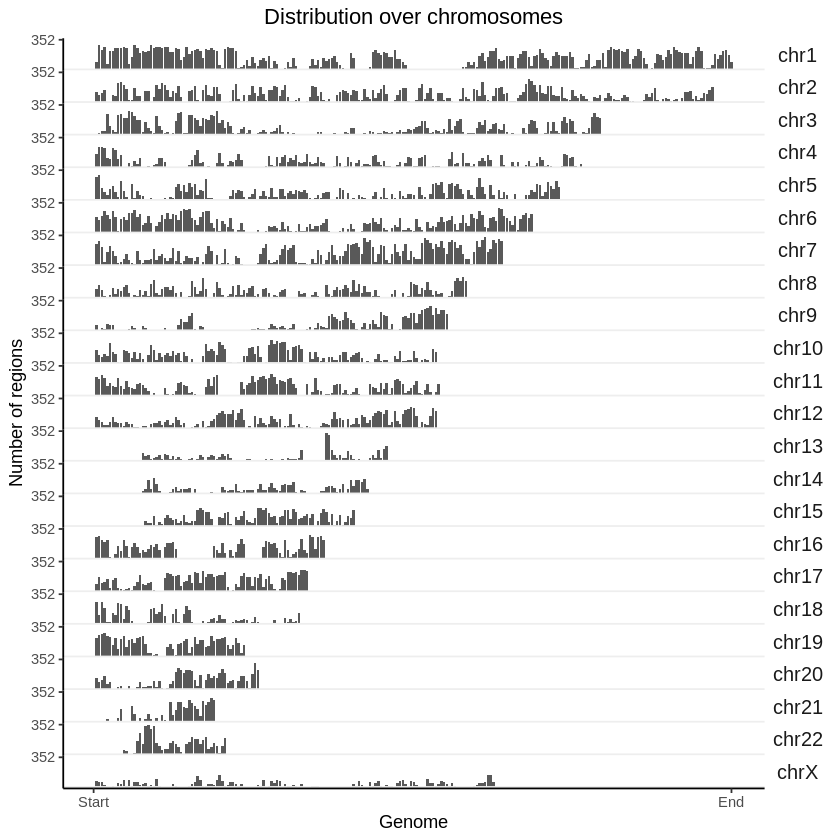

In [14]:
# First, calculate the distribution:
x = calcChromBinsRef(grg, "hg38")

# Then, plot the result:
plotChromBins(x)

## Split to different region

```
ASTARR | GATA1 | chrX:47,786,508-49,786,637
WSTARR | GATA1 | chrX:47,786,887-49,786,530
TMPRA  | GATA1 | chrX:47,786,401-49,786,750

ASTARR | MYC | chr8:126,735,973-128,736,166
WSTARR | MYC | chr8:126,735,996-128,736,142
TMPRA  | MYC | chr8:126,735,901-128,736,250
```

In [11]:
LOC_GATA1 = c( 47786500,  49786650)
LOC_MYC   = c(126735970, 128736170)

dat = dat_peak_nuc
dat_peak_gata1 = dat %>% dplyr::filter(Chrom == "chrX", Start >= LOC_GATA1[1], End <= LOC_GATA1[2])
dat_peak_myc   = dat %>% dplyr::filter(Chrom == "chr8", Start >= LOC_MYC[1],   End <= LOC_MYC[2])

In [12]:
print(dim(dat_peak_gata1))

[1] 197   5


In [13]:
print(dim(dat_peak_myc))

[1] 188   5


In [14]:
nrow(dat_peak_myc)

[1] 188

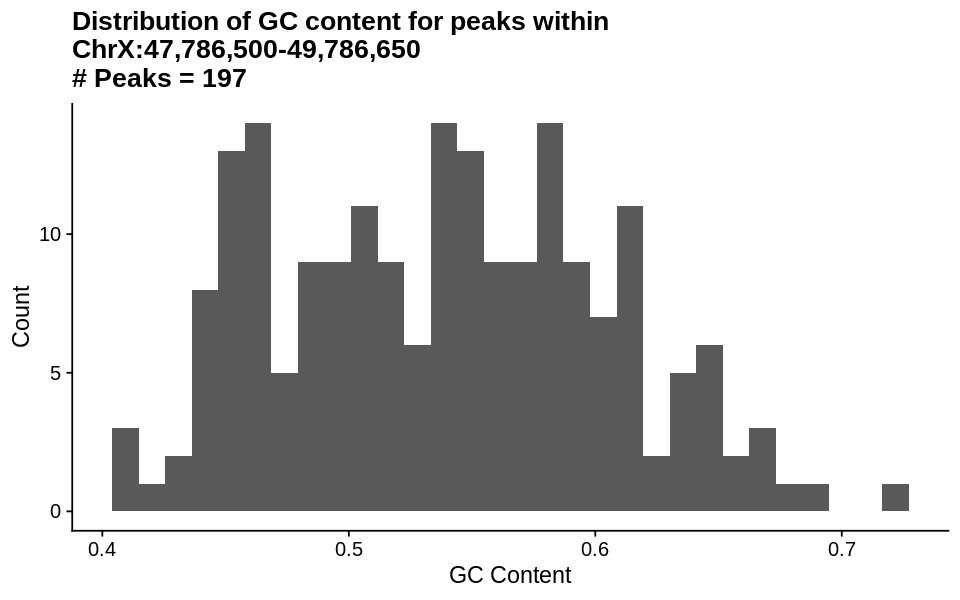

In [17]:
dat = dat_peak_gata1
txt = "ChrX:47,786,500-49,786,650"
gpt = ggplot(dat, aes(x=Pct_GC)) + 
    geom_histogram(bins=30) + 
    labs(x="GC Content", y="Count", 
         title=paste0(
             "Distribution of GC content for peaks within\n",
             txt, "\n", "# Peaks = ", nrow(dat))) +
    theme_cowplot()

options(repr.plot.height=5, repr.plot.width=8)
print(gpt)

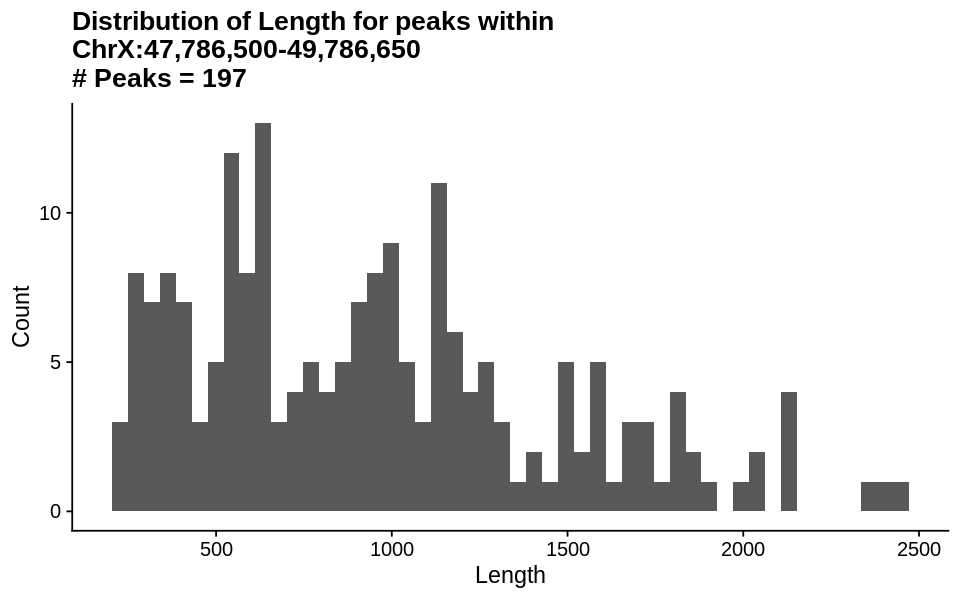

In [18]:
dat = dat_peak_gata1
txt = "ChrX:47,786,500-49,786,650"
gpt = ggplot(dat, aes(x=Len)) + 
    geom_histogram(bins=50) + 
    labs(x="Length", y="Count", 
         title=paste0(
             "Distribution of Length for peaks within\n",
             txt, "\n", "# Peaks = ", nrow(dat))) +
    theme_cowplot()

options(repr.plot.height=5, repr.plot.width=8)
print(gpt)

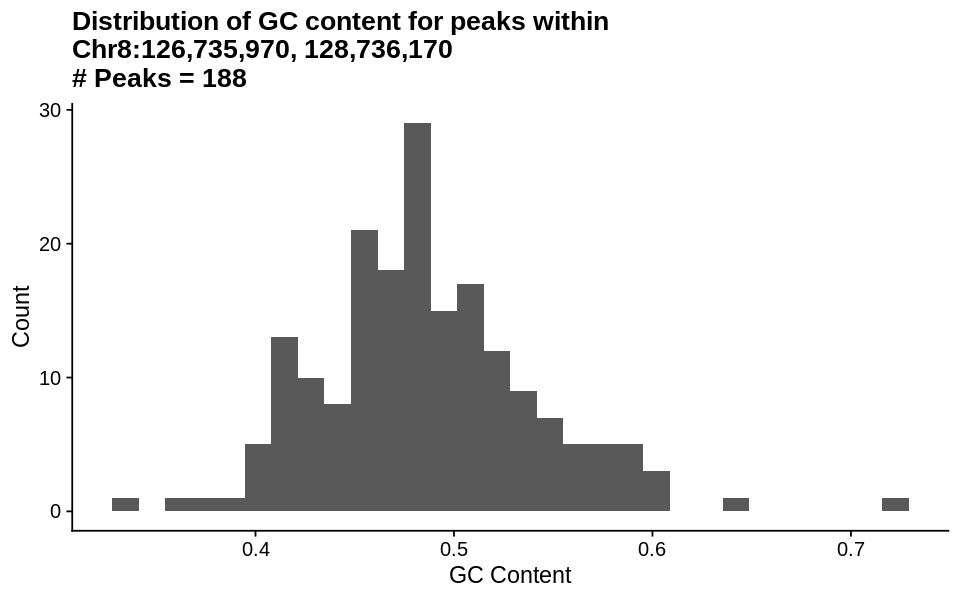

In [19]:
dat = dat_peak_myc
txt = "Chr8:126,735,970, 128,736,170"
gpt = ggplot(dat, aes(x=Pct_GC)) + 
    geom_histogram(bins=30) + 
    labs(x="GC Content", y="Count", 
         title=paste0(
             "Distribution of GC content for peaks within\n",
             txt, "\n", "# Peaks = ", nrow(dat))) +
    theme_cowplot()

options(repr.plot.height=5, repr.plot.width=8)
print(gpt)

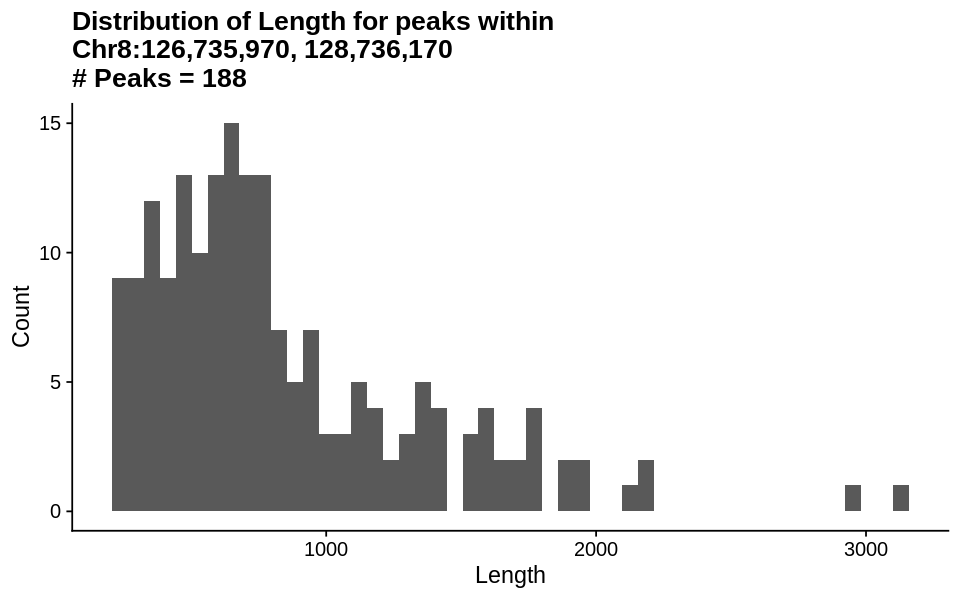

In [21]:
dat = dat_peak_myc
txt = "Chr8:126,735,970, 128,736,170"
gpt = ggplot(dat, aes(x=Len)) + 
    geom_histogram(bins=50) + 
    labs(x="Length", y="Count", 
         title=paste0(
             "Distribution of Length for peaks within\n",
             txt, "\n", "# Peaks = ", nrow(dat))) +
    theme_cowplot()

options(repr.plot.height=5, repr.plot.width=8)
print(gpt)